<a href="https://colab.research.google.com/github/Kaleb-Huneau/GAN-Group6/blob/Reduced-images/020824-Deven_trying_dataset_download_MRIdataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# New Section
# Run the code

In [ ]:
!git clone https://github.com/Kaleb-Huneau/GAN-Group6.git

fatal: destination path 'GAN-Group6' already exists and is not an empty directory.


[Kaggle](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset/data)

In [ ]:
import numpy as np
from tqdm import tqdm
import cv2
import os
import imutils
#Used preprocessing code from ABDALLAH WAGIH IBRAHIM


os.environ['KAGGLE_USERNAME'] = 'devenshidfar'
os.environ['KAGGLE_KEY'] = 'b02b3cac05e201958e7b16b470c54832'

!pip install kaggle

#!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset -p dataset

Preprocessing: for the brain MRI dataset [Brain tumor MRI](https://github.com/masoudnick/Brain-Tumor-MRI-Classification/blob/main/Preprocessing.py)


In [ ]:
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# # Data preprocessing and augmentation
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    #transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# train_dataset = ImageFolder('GAN-Group6/Dataset/notumor/Training', transform=data_transforms)
# train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# val_dataset = ImageFolder('GAN-Group6/Dataset/notumor/Testing', transform=data_transforms)
# val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)



Justins code:

In [ ]:
os.getcwd()

'/content'

In [ ]:
import os
import time
import tensorflow as tf
#import tensorflow_probability as tfp
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, \
    LeakyReLU, Conv2DTranspose, Conv2D, Dropout, \
        Flatten, Reshape, ReLU, Input, Concatenate
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Activation
from tensorflow.python.data import Iterator
import numpy as np
import pandas as pd
import scipy as sp
import sys
import multiprocessing
import argparse
import numpy as np
import matplotlib.pyplot as plt
#import stacked_mnist

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

#tfd = tfp.distributions

def make_directory(PATH):
    if not os.path.exists(PATH):
            os.mkdir(PATH)


class AlphaGAN(object):
    def __init__(self, opt):
        self.opt = opt
        self.batch_size = 16
        self.noise_dim = 224*224
        self.epsilon = 1e-8
        self.alpha_d = float(opt.alpha_d)
        self.alpha_g = float(opt.alpha_g)
        self.seed = opt.seed
        self.loss_type = opt.loss_type
        self.dataset = opt.dataset
        self.n_epochs = opt.n_epochs
        self.gp = opt.gp
        self.scores = np.zeros(self.n_epochs)
        self.num_images = opt.num_images
        self.gp_coef = opt.gp_coef
        if self.dataset != 'cifar10':
            self.num_images = 10
        self.d_opt = Adam(2e-4, beta_1 = 0.5)
        self.g_opt = Adam(2e-4, beta_1 = 0.5)
        if self.dataset == 'cifar10':
            self.noise_dim = 100
        self.l1 = opt.l1
        tf.random.set_seed(self.seed)
        np.random.seed(self.seed)


    def get_data(self):
        if self.dataset == 'mnist':
            (self.train_img, _), (self.test_img, _) = tf.keras.datasets.mnist.load_data()
            self.train_img = self.train_img.reshape(self.train_img.shape[0], 28, 28, 1)
            self.test_img = self.test_img.reshape(self.test_img.shape[0], 28, 28, 1)

        elif self.dataset == 'cifar10':
            (self.train_img, _), (self.test_img, _) = tf.keras.datasets.cifar10.load_data()
            self.train_img = self.train_img.reshape(self.train_img.shape[0], 32, 32, 3)
            self.test_img = self.test_img.reshape(self.test_img.shape[0], 32, 32, 3)

        elif self.dataset == 'stacked-mnist':
            (self.train_img, _), (self.test_img, _) = stacked_mnist.load_data()
            self.train_img = self.train_img.reshape(self.train_img.shape[0], 32, 32, 3)
            self.test_img = self.test_img.reshape(self.test_img.shape[0], 32, 32, 3)

        elif self.dataset == 'mri':

            train_dataset = ImageFolder('/content/GAN-Group6/Dataset/Testing/', transform=data_transforms)
            val_dataset = ImageFolder('/content/GAN-Group6/Dataset/Testing/', transform=data_transforms)

            print("Working before self.train_img")

            self.train_img = []
            for inputs, _ in DataLoader(train_dataset, batch_size=16, shuffle=True):
                self.train_img.append(inputs.numpy())
            self.train_img = np.concatenate(self.train_img, axis=0)

            print("Working after self.train_img")

            self.test_img = []
            for inputs, _ in DataLoader(val_dataset, batch_size=16, shuffle=False):
                self.test_img.append(inputs.numpy())
            self.test_img = np.concatenate(self.test_img, axis=0)

            # Normalize data to be between 0 and 1
            # self.train_img = (self.train_img - np.min(self.train_img)) / (np.max(self.train_img) - np.min(self.train_img))
            # self.test_img = (self.test_img - np.min(self.test_img)) / (np.max(self.test_img) - np.min(self.test_img))

            print(self.train_img.shape)
            print(self.test_img.shape)

            self.train_img = self.train_img[:100]
            self.test_img = self.test_img[:100]

            print("Now",self.train_img.shape)
            print("Now",self.test_img.shape)

        #elif self.dataset == ''

        #self.real_mu, self.real_sigma = self.get_eval_metrics(self.train_img)
        self.train_data, self.test_data = self.clean_data(self.train_img, train = True), self.clean_data(self.test_img, train = False)

    # GET THIS TO WORK AFTER
    # def get_eval_metrics(self, data):
    #     img_dims = data.shape
    #     eval_img = data[np.random.choice(img_dims[0], 10000, replace=False), :, :, :]
    #     eval_img = eval_img.reshape(10000, np.prod(img_dims[1:])).astype('float32')
    #     eval_img = eval_img / 255.0
    #     real_mu = eval_img.mean(axis = 0)
    #     eval_img = np.transpose(eval_img)
    #     real_sigma = np.cov(eval_img)
    #     return real_mu, real_sigma

    def clean_data(self, data, train):

        new_data = data.astype('float32')
        new_data = (new_data - 127.5) / 127.5
        if train:
            new_data = tf.data.Dataset.from_tensor_slices(new_data)
            return new_data.shuffle(100000).batch(self.batch_size)
        return new_data

    def gen_loss_vanilla(self):
        bce = tf.keras.losses.BinaryCrossentropy(from_logits = False)
        loss_expr =  bce(tf.ones_like(self.fake_predicted_labels), self.fake_predicted_labels)
        if self.l1:
            loss_expr = tf.math.abs(loss_expr - (-tf.math.log(2.0)))
        return loss_expr

    def gen_loss_vanilla_l1(self):
        return tf.math.abs(self.gen_loss_vanilla() - (-tf.math.log(2.0)))


    def gen_loss_alpha(self):
        fake_expr = tf.math.pow(1 - self.fake_predicted_labels, ((self.alpha_g-1)/self.alpha_g)*tf.ones_like(self.fake_predicted_labels))
        fake_loss = tf.math.reduce_mean(fake_expr)
        loss_expr = (self.alpha_g/(self.alpha_g - 1))*(fake_loss - 2.0)
        if self.l1:
            equil_val = (self.alpha_g)/(self.alpha_g - 1)*(tf.math.pow(2.0, 1/self.alpha_g) - 2)
            loss_expr = tf.math.abs(loss_expr - equil_val)
        return loss_expr

    def dis_loss_vanilla(self):
        bce = tf.keras.losses.BinaryCrossentropy(from_logits = False)
        real_loss = bce(tf.ones_like(self.real_predicted_labels), self.real_predicted_labels)
        fake_loss = bce(tf.zeros_like(self.fake_predicted_labels), self.fake_predicted_labels)
        r1_penalty = 0
        if self.gp:
            gradients = tf.gradients(-tf.math.log(1 / self.real_predicted_labels - 1), [self.img])[0]
            r1_penalty = tf.reduce_mean(tf.reduce_sum(tf.square(gradients), axis=[1, 2, 3]))
        return real_loss + fake_loss + self.gp_coef*r1_penalty

    def dis_loss_alpha(self):
        real_expr = tf.math.pow(self.real_predicted_labels, ((self.alpha_d-1)/self.alpha_d)*tf.ones_like(self.real_predicted_labels))
        real_loss = tf.math.reduce_mean(real_expr)
        fake_expr = tf.math.pow(1 - self.fake_predicted_labels, ((self.alpha_d-1)/self.alpha_d)*tf.ones_like(self.fake_predicted_labels))
        fake_loss = tf.math.reduce_mean(fake_expr)
        r1_penalty = 0
        if self.gp:
            gradients = tf.gradients(-tf.math.log(1 / self.real_predicted_labels - 1), [self.img])[0]
            r1_penalty = tf.reduce_mean(tf.reduce_sum(tf.square(gradients), axis=[1, 2, 3]))
        loss_expr = -(self.alpha_d/(self.alpha_d - 1))*(real_loss + fake_loss - 2.0)


        return loss_expr + self.gp_coef*r1_penalty





    def build_generator(self):



        if self.dataset == 'mnist':

            model = Sequential(name = "mnist_generator")

            model.add(Dense(7 * 7 * 256, use_bias=False, kernel_initializer=
            RandomNormal(mean=0.0, stddev=0.01), input_shape=(self.noise_dim,)))
            model.add(BatchNormalization())
            model.add(LeakyReLU())

            model.add(Reshape((7, 7, 256)))


            model.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False, kernel_initializer=
            RandomNormal(mean=0.0, stddev=0.01)))

            model.add(BatchNormalization())
            model.add(LeakyReLU())

            model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=
            RandomNormal(mean=0.0, stddev=0.01)))

            model.add(BatchNormalization())
            model.add(LeakyReLU())

            model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', activation='tanh', use_bias=False,
                                        kernel_initializer=RandomNormal(mean=0.0, stddev=0.01)))


        elif self.dataset == 'cifar10' or self.dataset == 'stacked-mnist':

            model = Sequential(name = "cifar10_generator")

            model.add(Dense(256*4*4, input_shape=(self.noise_dim,)))
            model.add(LeakyReLU(0.2))
            model.add(BatchNormalization())
            model.add(Reshape((4, 4, 256)))

            model.add(Conv2DTranspose(128, (4,4), strides = (2,2), padding = 'same'))
            model.add(BatchNormalization())
            model.add(LeakyReLU(0.2))

            model.add(Conv2DTranspose(128, (4,4), strides = (2,2), padding = 'same'))
            model.add(BatchNormalization())
            model.add(LeakyReLU(0.2))

            model.add(Conv2DTranspose(128, (4,4), strides = (2,2), padding = 'same'))
            model.add(BatchNormalization())
            model.add(LeakyReLU(0.2))

            model.add(Conv2D(3, (3, 3), activation='tanh', padding = 'same'))

        elif self.dataset == 'mri':

            model = Sequential(name = "mri_generator")

            model.add(Dense(4*4*224, input_shape=(self.noise_dim,)))
            model.add(LeakyReLU(0.2))
            model.add(BatchNormalization())
            model.add(Reshape((4, 4, 224)))

            model.add(Conv2DTranspose(128, (4,4), strides = (2,2), padding = 'same'))
            model.add(BatchNormalization())
            model.add(LeakyReLU(0.2))

            model.add(Conv2DTranspose(128, (4,4), strides = (2,2), padding = 'same'))
            model.add(BatchNormalization())
            model.add(LeakyReLU(0.2))

            model.add(Conv2DTranspose(128, (4,4), strides = (2,2), padding = 'same'))
            model.add(BatchNormalization())
            model.add(LeakyReLU(0.2))


            model.add(Conv2DTranspose(64, (3,3), strides=(2,2), padding='same'))

            model.add(BatchNormalization())
            model.add(LeakyReLU(0.2))
            #upscales the image to 64x64.

            model.add(Conv2DTranspose(64, (3,3), strides=(2,2), padding='same'))
            model.add(BatchNormalization())
            model.add(LeakyReLU(0.2))
            #upscaled to 128x128.

            model.add(Conv2DTranspose(64, (3,3), strides=(2,2), padding='same'))
            model.add(BatchNormalization())
            model.add(LeakyReLU(0.2))
            #  the image is 256x256.

            # Final adjustment to reach 224x224.
            from tensorflow.keras.layers import Resizing
            model.add(Resizing(224, 224, interpolation='bilinear'))
            # Now the image is exactly 224x224.

            model.add(Conv2D(3, (3, 3), activation='tanh', padding='same'))
            #convolution to adjust channel size to 3.


        print("Generator model:")
        model.summary()
        return model


    def build_dq(self):


        if self.dataset == 'mnist':

            model = Sequential(name = "mnist_discriminator")
            model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', kernel_initializer=
            RandomNormal(mean=0.0, stddev=0.01)))
            model.add(LeakyReLU())
            model.add(Dropout(0.3))

            model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same', kernel_initializer=
            RandomNormal(mean=0.0, stddev=0.01)))
            model.add(LeakyReLU())
            model.add(Dropout(0.3))

            model.add(Flatten())
            model.add(Dense(1, activation='sigmoid', kernel_initializer=
            RandomNormal(mean=0.0, stddev=0.01)))

        elif self.dataset == 'cifar10' or self.dataset == 'stacked-mnist':
            model = Sequential(name = "cifar10_discriminator")
            model.add(Conv2D(64, (3, 3), padding='same', input_shape=(32, 32, 3)))
            model.add(LeakyReLU(0.2))

            model.add(Conv2D(128, (3, 3), strides = (2, 2), padding = 'same'))
            model.add(LeakyReLU(0.2))

            model.add(Conv2D(128, (3, 3), strides = (2, 2), padding = 'same'))
            model.add(LeakyReLU(0.2))

            model.add(Conv2D(256, (3, 3), strides = (2, 2), padding = 'same'))
            model.add(LeakyReLU(0.2))

            model.add(Flatten())
            model.add(Dropout(0.4))
            model.add(Dense(1, activation='sigmoid'))

        elif self.dataset == 'mri':
            model = Sequential(name = "mri_discriminator")
            model.add(Conv2D(64, (3, 3), padding='same', input_shape=(224, 224,3)))
            model.add(LeakyReLU(0.2))

            model.add(Conv2D(128, (3, 3), strides = (1, 1), padding = 'same'))
            model.add(LeakyReLU(0.2))

            model.add(Conv2D(128, (3, 3), strides = (1, 1), padding = 'same'))
            model.add(LeakyReLU(0.2))

            model.add(Conv2D(256, (3, 3), strides = (1, 1), padding = 'same'))
            model.add(LeakyReLU(0.2))

            model.add(Flatten())
            model.add(Dropout(0.4))
            model.add(Dense(1, activation='sigmoid'))
        print("Discriminator Model:")
        model.summary()
        return model

    def build_gan(self):
        self.generator = self.build_generator()
        self.discriminator = self.build_dq()
        self.generator_loss = self.gen_loss_alpha
        self.discriminator_loss = self.dis_loss_alpha
        if self.alpha_d == 1.0:
            self.discriminator_loss = self.dis_loss_vanilla
        if self.alpha_g == 1.0:
            self.generator_loss = self.gen_loss_vanilla

    @tf.function
    def train_step(self, real_images):

        z = tf.random.normal([self.batch_size, self.noise_dim])
        with tf.GradientTape() as gen_tape, tf.GradientTape() as dis_tape, tf.GradientTape() as q_tape:
            self.discriminator.trainable = True
            self.img = real_images
            self.real_predicted_labels = self.discriminator(real_images, training = True)

            self.generated_images = self.generator(z, training = True)
            self.fake_predicted_labels = self.discriminator(self.generated_images, training = True)

            self.dis_loss_value = self.discriminator_loss()
            self.gen_loss_value = self.generator_loss()

        dis_gradients = dis_tape.gradient(self.dis_loss_value, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(dis_gradients, self.discriminator.trainable_variables))
        self.discriminator.trainable = False
        gen_gradients = gen_tape.gradient(self.gen_loss_value, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(gen_gradients, self.generator.trainable_variables))

        return self.dis_loss_value, self.gen_loss_value

    def build_directory(self):
        gan_name = 'AlphaGAN'
        if self.alpha_d == 1.0 and self.alpha_g == 1.0:
            gan_name = 'VanillaGAN'
        '''
        SEEDS = [123, 1600, 60677, 15859, 79878]
        if self.dataset == 'mnist':
            SEEDS = [123, 500, 1600, 199621, 60677, 20435, 15859, 33764, 79878, 36123]
        '''
        make_directory(gan_name)
        make_directory(f'{gan_name}/{self.dataset}')
        if gan_name == 'AlphaGAN':
            make_directory(f'{gan_name}/{self.dataset}/alpha-d{self.alpha_d}-g{self.alpha_g}')

        subfolders = [f[0] for f in os.walk(f'AlphaGAN/{self.dataset}/alpha-d{self.alpha_d}-g{self.alpha_g}')]
        folders = [f for f in subfolders if f.startswith(f'AlphaGAN/{self.dataset}/alpha-d{self.alpha_d}-g{self.alpha_g}/v')]

        versions = [f.split('/v')[1] for f in folders]
        versions = [int(v) for v in versions if v.isnumeric()]
        version = 1
        if versions:
            version = max(versions) + 1
        folder_created = False

        while not folder_created:
            self.path = f'AlphaGAN/{self.dataset}/alpha-d{self.alpha_d}-g{self.alpha_g}/v'+str(version)

            try:
                make_directory(self.path)
                folder_created = True
            except:
                version += 1
        '''

        version = SEEDS.index(self.seed) + 1
        if self.gp and self.l1:
            version = version + 15 if self.dataset != 'mnist' else version + 30
        elif self.gp:
            version = version + 5 if self.dataset != 'mnist' else version + 10
        elif self.l1:
            version = version + 10 if self.dataset != 'mnist' else version + 20
        '''
        self.path = f'{gan_name}/{self.dataset}/alpha-d{self.alpha_d}-g{self.alpha_g}/v'+str(version)
        if gan_name == 'VanillaGAN':
            self.path = f'{gan_name}/{self.dataset}/v'+str(version)

        make_directory(self.path)
        make_directory(self.path + '/metrics')
        make_directory(self.path + '/metrics/accuracy')
        make_directory(self.path + '/metrics/losses')
        make_directory(self.path + '/img')
        make_directory(self.path + '/models')

        with open(self.path+'/description.txt', 'w') as f:
            f.write(f'version={version}\n')
            for k, v in vars(self.opt).items():
                f.write(f'{k}={v}')
                f.write('\n')


    def train(self):
        self.get_data()
        self.build_gan()
        self.build_directory()
        gen_loss_history = np.zeros(self.n_epochs)
        dis_loss_history = np.zeros(self.n_epochs)
        epoch_times = []
        img_times = []
        epochs_passed = 0
        for epoch in range(1, self.n_epochs + 1):
            print(f"Epoch {epoch}")
            n_batches = 0
            start_epoch = time.time()
            for real_images in iter(self.train_data):

                # print("Real image shape: ", real_images.shape)
                real_images = np.transpose(real_images, (0, 2, 3, 1))
                # print("Real image shape after: ", real_images.shape)
                img_reverted = 0.229 * real_images[0] + 0.485

                img_clipped = np.clip(img_reverted, 0, 1)

                print(img_clipped)
                plt.imshow(img_clipped)
                plt.show()

                print(real_images[0])
                plt.imshow(real_images[0])
                plt.show()

                dis_loss_value, gen_loss_value = self.train_step(real_images)

                gen_loss_history[epoch - 1] += gen_loss_value
                dis_loss_history[epoch - 1] += dis_loss_value

                n_batches += 1
            gen_loss_history = gen_loss_history/n_batches
            dis_loss_history = dis_loss_history/n_batches
            end_epoch = time.time()
            epoch_times.append(end_epoch - start_epoch)
            #self.evaluate(epoch)
            start_img = time.time()
            self.save_generated_images(epoch)
            end_img = time.time()
            img_times.append(end_img - start_img)
            epochs_passed += 1
            # try:
            #     self.scores[epoch - 1] = self.compute_fid()
            # except Exception as e:
            #     print(str(e))
            #     break


        np.save(self.path + '/metrics/losses/gen_loss.npy', gen_loss_history)
        np.save(self.path + '/metrics/losses/dis_loss.npy', dis_loss_history)

        self.generator.save(self.path+ '/models/generator')
        self.discriminator.save(self.path + '/models/discriminator')

        time_df = pd.DataFrame({'epoch':list(range(1, epochs_passed + 1)),
        'epoch_time':epoch_times, 'img_times':img_times})

        time_df.to_pickle(self.path+'/times.pkl')
        np.save(self.path + '/scores.npy', self.scores)
        if epochs_passed == self.n_epochs:
            for epoch in range(epochs_passed):
                if epoch != np.nanargmin(self.scores):
                    os.remove(self.path + '/img/predictions' + str(epoch + 1) + ".npy")



    def compute_fid(self):
        fake_images = self.generator(tf.random.normal([10000, self.noise_dim]))
        fake_images = fake_images.numpy()
        if self.dataset == 'mnist':
            fake_images = fake_images.reshape(10000, 28*28)
        elif self.dataset == 'cifar10':
            fake_images = fake_images.reshape(10000, 32*32*3)
        elif self.dataset == 'stacked-mnist':
            fake_images = fake_images.reshape(10000, 32*32*3)
        fake_images = (fake_images * 127.5 + 127.5) / 255.0
        fake_mu = fake_images.mean(axis=0)
        fake_sigma = np.cov(np.transpose(fake_images))
        covSqrt = sp.linalg.sqrtm(np.matmul(fake_sigma, self.real_sigma))
        if np.iscomplexobj(covSqrt):
            covSqrt = covSqrt.real
        fidScore = np.linalg.norm(self.real_mu - fake_mu) + np.trace(self.real_sigma + fake_sigma - 2 * covSqrt)
        return fidScore



    def save_generated_images(self, epoch):
        if epoch == 1:
            self.z_eval = tf.random.normal([self.num_images, self.noise_dim])


        imgs = self.generator(self.z_eval, training = False)
        print(imgs.shape)

        np.save(self.path+'/img/predictions' + str(epoch) + '.npy', imgs)

    # def print_dataset(self):


    #     image = np.transpose(self.train_img, (0, 2, 3, 1))
    #     plt.imshow(self.train_img[0])
    #     plt.show()




In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# import matplotlib

# filename = "/content/AlphaGAN/mnist/alpha-d3.0-g3.0/v2/img/predictions1.npy"

# # Load the numpy file
# img_array = np.load(filename, allow_pickle=True)

# # Normalize the data to [0, 1]
# img_array_normalized = (img_array - img_array.min()) / (img_array.max() - img_array.min())

# # Add the channel dimension back
# img_array_normalized_with_channel = img_array_normalized[ :, np.newaxis]

# # Display the image
# plt.imshow(img_array_normalized_with_channel.squeeze(), cmap="gray")
# plt.axis('off')  # Turn off axis labels
# plt.show()

# # Save the image
# img_name = filename + ".png"
# matplotlib.image.imsave(img_name, img_array_normalized.squeeze(), cmap="gray")
# print(f"Image saved as {img_name}")

Working before self.train_img
Working after self.train_img
(1311, 3, 224, 224)
(1311, 3, 224, 224)
Now (100, 3, 224, 224)
Now (100, 3, 224, 224)
Generator model:
Model: "mri_generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 3584)              179834368 
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 3584)              0         
                                                                 
 batch_normalization (Batch  (None, 3584)              14336     
 Normalization)                                                  
                                                                 
 reshape (Reshape)           (None, 4, 4, 224)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 8, 8, 128)         458880    
 anspose)              

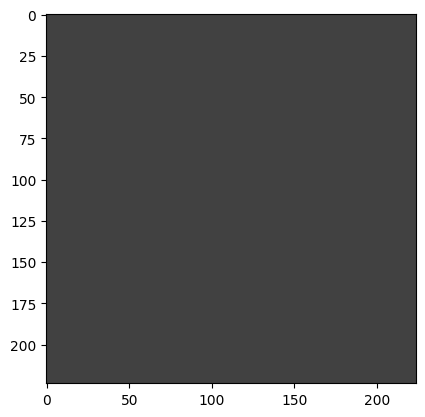

[[[-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 [[-0.99996924 -0.99996924 -0.99996924]
  [-0.99996924 -0.99996924 -0.99996924]
  [-0.99996924 -0.99996924 -0.99996924]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 [[-0.9999385  -0.9999385  -0.9999385 ]
  [-0.9999385  -0.9999385  -0.9999385 ]
  [-0.9999385  -0.9999385  -0.9999385 ]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 ...

 [[-0.9999385  -0.9999385  -0.9999385 ]
  [-0.9999385  -0.9999385  -0.9999385 ]
  [-0.9999385  -0.9999385  -0.9999385 ]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 [

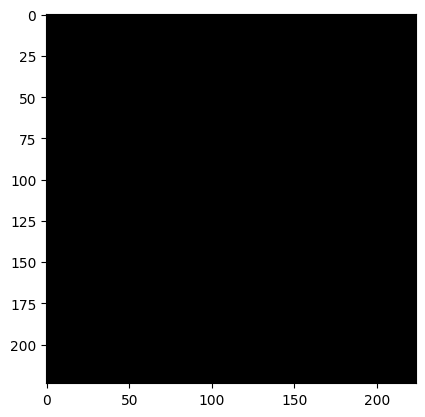

[[[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 ...

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]]


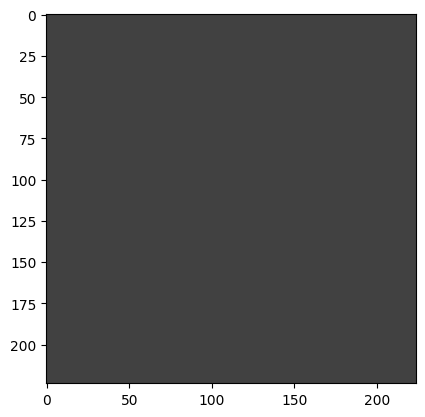

[[[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 ...

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]]


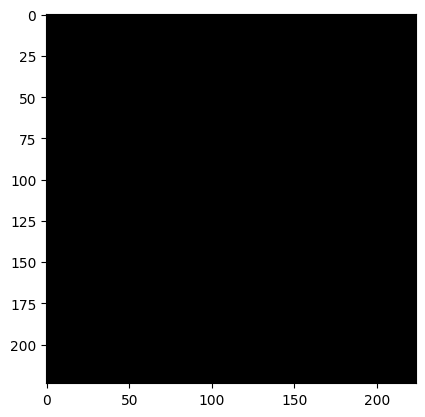

[[[0.256     0.256     0.256    ]
  [0.256     0.256     0.256    ]
  [0.256     0.256     0.256    ]
  ...
  [0.256     0.256     0.256    ]
  [0.256     0.256     0.256    ]
  [0.256     0.256     0.256    ]]

 [[0.256     0.256     0.256    ]
  [0.256     0.256     0.256    ]
  [0.256     0.256     0.256    ]
  ...
  [0.256     0.256     0.256    ]
  [0.256     0.256     0.256    ]
  [0.256     0.256     0.256    ]]

 [[0.256     0.256     0.256    ]
  [0.256     0.256     0.256    ]
  [0.256     0.256     0.256    ]
  ...
  [0.2560141 0.2560141 0.2560141]
  [0.2560141 0.2560141 0.2560141]
  [0.2560141 0.2560141 0.2560141]]

 ...

 [[0.256     0.256     0.256    ]
  [0.256     0.256     0.256    ]
  [0.256     0.256     0.256    ]
  ...
  [0.2560141 0.2560141 0.2560141]
  [0.2560141 0.2560141 0.2560141]
  [0.2560141 0.2560141 0.2560141]]

 [[0.256     0.256     0.256    ]
  [0.256     0.256     0.256    ]
  [0.256     0.256     0.256    ]
  ...
  [0.256     0.256     0.256    ]
  [0

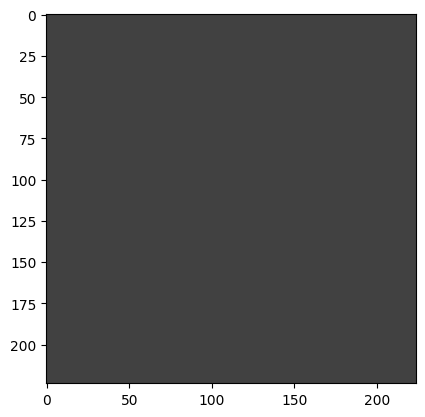

[[[-1.        -1.        -1.       ]
  [-1.        -1.        -1.       ]
  [-1.        -1.        -1.       ]
  ...
  [-1.        -1.        -1.       ]
  [-1.        -1.        -1.       ]
  [-1.        -1.        -1.       ]]

 [[-1.        -1.        -1.       ]
  [-1.        -1.        -1.       ]
  [-1.        -1.        -1.       ]
  ...
  [-1.        -1.        -1.       ]
  [-1.        -1.        -1.       ]
  [-1.        -1.        -1.       ]]

 [[-1.        -1.        -1.       ]
  [-1.        -1.        -1.       ]
  [-1.        -1.        -1.       ]
  ...
  [-0.9999385 -0.9999385 -0.9999385]
  [-0.9999385 -0.9999385 -0.9999385]
  [-0.9999385 -0.9999385 -0.9999385]]

 ...

 [[-1.        -1.        -1.       ]
  [-1.        -1.        -1.       ]
  [-1.        -1.        -1.       ]
  ...
  [-0.9999385 -0.9999385 -0.9999385]
  [-0.9999385 -0.9999385 -0.9999385]
  [-0.9999385 -0.9999385 -0.9999385]]

 [[-1.        -1.        -1.       ]
  [-1.        -1.        -1.       ]


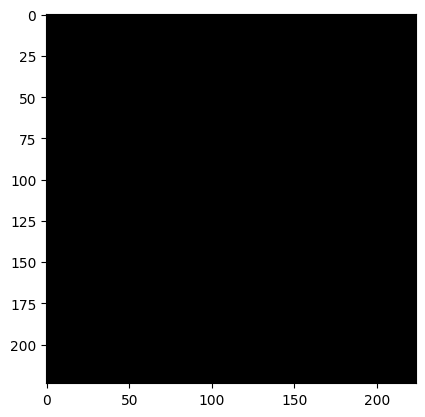

[[[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 ...

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]]


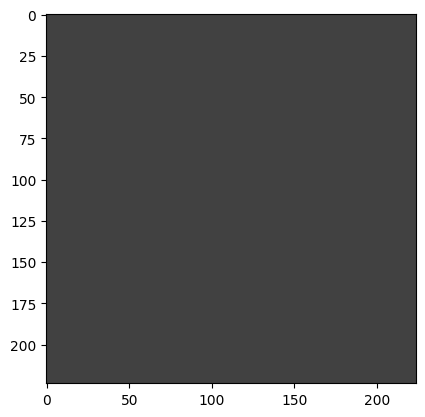

[[[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 ...

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]]


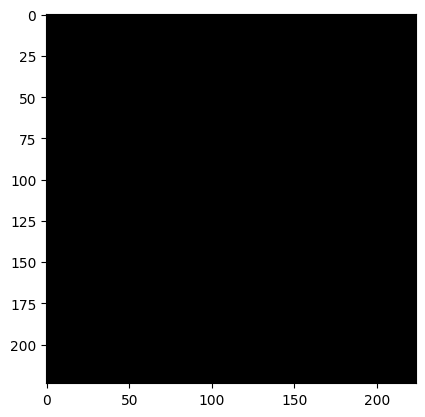

[[[0.25602114 0.25602114 0.25602114]
  [0.25602114 0.25602114 0.25602114]
  [0.25602114 0.25602114 0.25602114]
  ...
  [0.256      0.256      0.256     ]
  [0.256      0.256      0.256     ]
  [0.256      0.256      0.256     ]]

 [[0.25600708 0.25600708 0.25600708]
  [0.25600708 0.25600708 0.25600708]
  [0.25600708 0.25600708 0.25600708]
  ...
  [0.256      0.256      0.256     ]
  [0.256      0.256      0.256     ]
  [0.256      0.256      0.256     ]]

 [[0.256      0.256      0.256     ]
  [0.256      0.256      0.256     ]
  [0.256      0.256      0.256     ]
  ...
  [0.256      0.256      0.256     ]
  [0.256      0.256      0.256     ]
  [0.256      0.256      0.256     ]]

 ...

 [[0.256      0.256      0.256     ]
  [0.256      0.256      0.256     ]
  [0.256      0.256      0.256     ]
  ...
  [0.256      0.256      0.256     ]
  [0.256      0.256      0.256     ]
  [0.256      0.256      0.256     ]]

 [[0.256      0.256      0.256     ]
  [0.256      0.256      0.256     ]


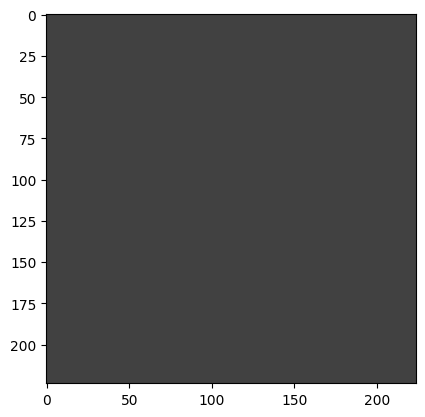

[[[-0.99990773 -0.99990773 -0.99990773]
  [-0.99990773 -0.99990773 -0.99990773]
  [-0.99990773 -0.99990773 -0.99990773]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 [[-0.99996924 -0.99996924 -0.99996924]
  [-0.99996924 -0.99996924 -0.99996924]
  [-0.99996924 -0.99996924 -0.99996924]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 [[-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 ...

 [[-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 [

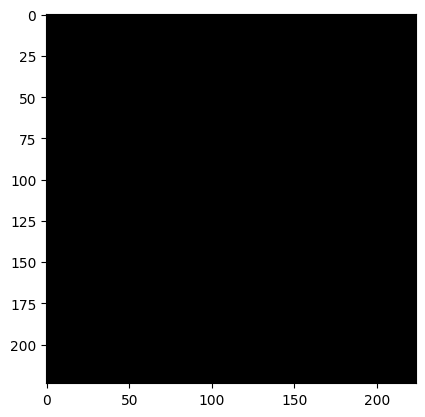

[[[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 ...

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]]


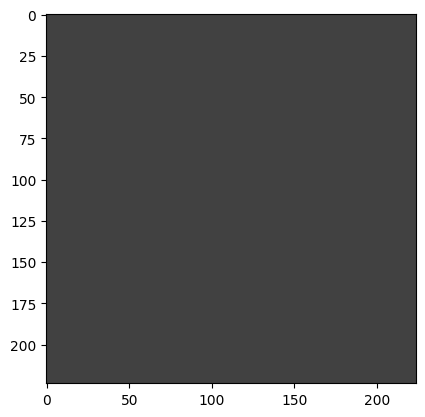

[[[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 ...

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]]


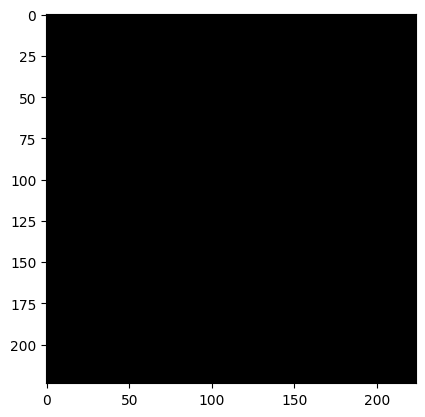

[[[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 ...

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]]


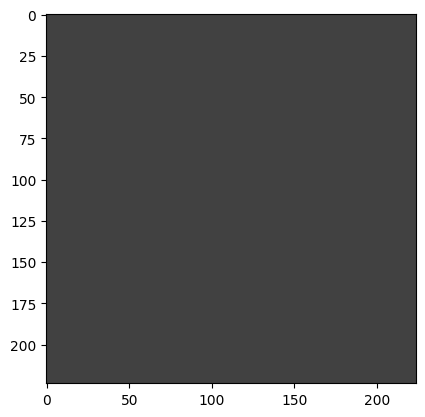

[[[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 ...

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]]


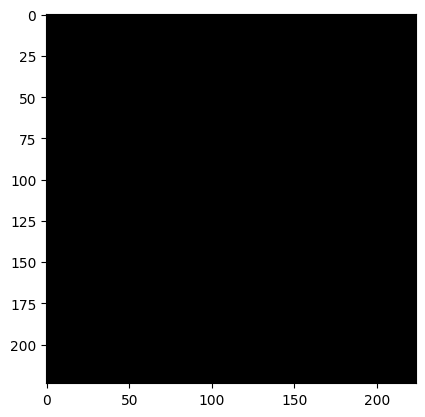

(10, 224, 224, 3)
Epoch 2
[[[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 ...

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]]


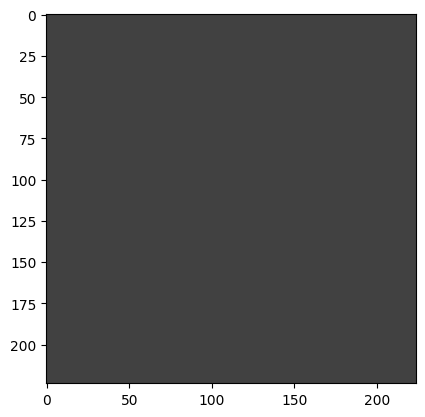

[[[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 ...

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]]


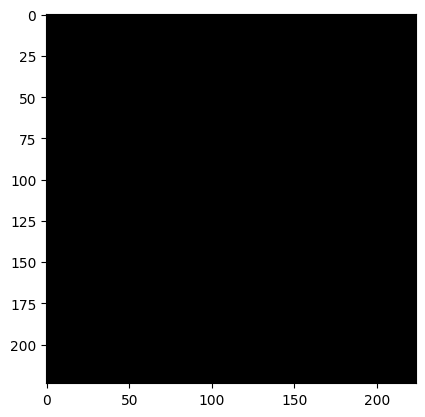

[[[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 ...

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]]


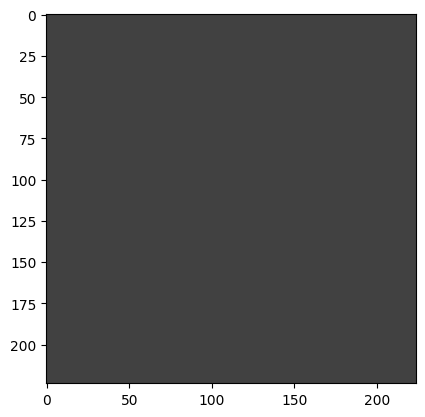

[[[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 ...

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]]


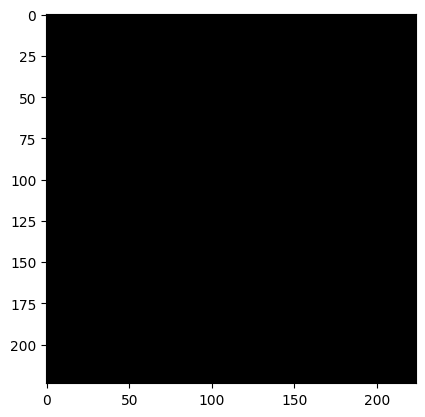

[[[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 ...

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]]


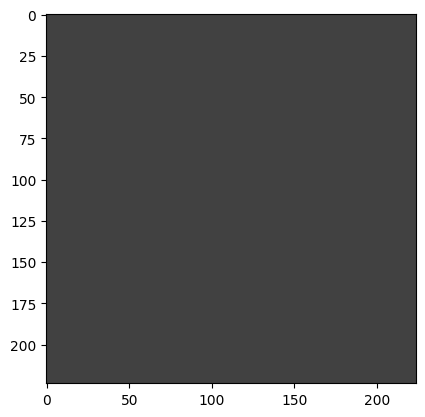

[[[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 ...

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]]


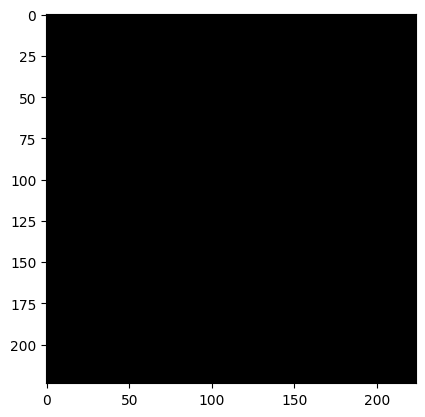

[[[0.25600708 0.25600708 0.25600708]
  [0.25600708 0.25600708 0.25600708]
  [0.25600708 0.25600708 0.25600708]
  ...
  [0.256      0.256      0.256     ]
  [0.256      0.256      0.256     ]
  [0.256      0.256      0.256     ]]

 [[0.25600708 0.25600708 0.25600708]
  [0.25600708 0.25600708 0.25600708]
  [0.25600708 0.25600708 0.25600708]
  ...
  [0.256      0.256      0.256     ]
  [0.256      0.256      0.256     ]
  [0.256      0.256      0.256     ]]

 [[0.25600708 0.25600708 0.25600708]
  [0.25600708 0.25600708 0.25600708]
  [0.25600708 0.25600708 0.25600708]
  ...
  [0.256      0.256      0.256     ]
  [0.256      0.256      0.256     ]
  [0.256      0.256      0.256     ]]

 ...

 [[0.25604227 0.25604227 0.25604227]
  [0.256      0.256      0.256     ]
  [0.2560141  0.2560141  0.2560141 ]
  ...
  [0.256      0.256      0.256     ]
  [0.256      0.256      0.256     ]
  [0.256      0.256      0.256     ]]

 [[0.2560141  0.2560141  0.2560141 ]
  [0.25600708 0.25600708 0.25600708]


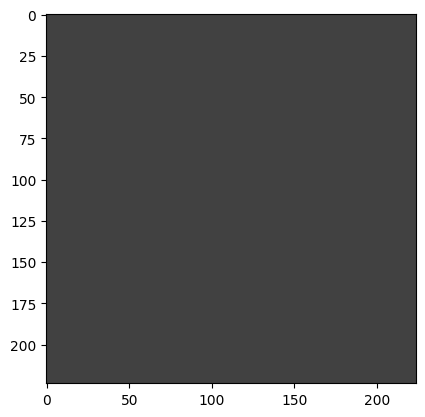

[[[-0.99996924 -0.99996924 -0.99996924]
  [-0.99996924 -0.99996924 -0.99996924]
  [-0.99996924 -0.99996924 -0.99996924]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 [[-0.99996924 -0.99996924 -0.99996924]
  [-0.99996924 -0.99996924 -0.99996924]
  [-0.99996924 -0.99996924 -0.99996924]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 [[-0.99996924 -0.99996924 -0.99996924]
  [-0.99996924 -0.99996924 -0.99996924]
  [-0.99996924 -0.99996924 -0.99996924]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 ...

 [[-0.99981546 -0.99981546 -0.99981546]
  [-1.         -1.         -1.        ]
  [-0.9999385  -0.9999385  -0.9999385 ]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 [

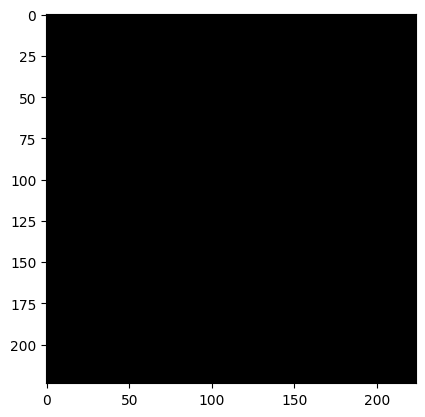

[[[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 ...

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]]


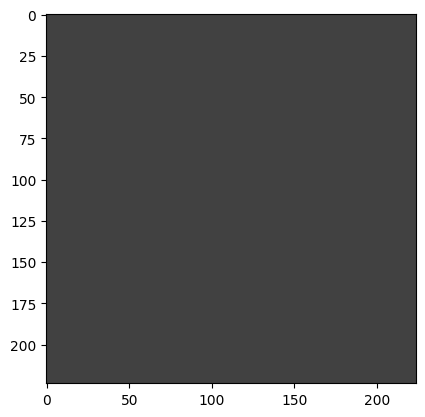

[[[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 ...

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]]


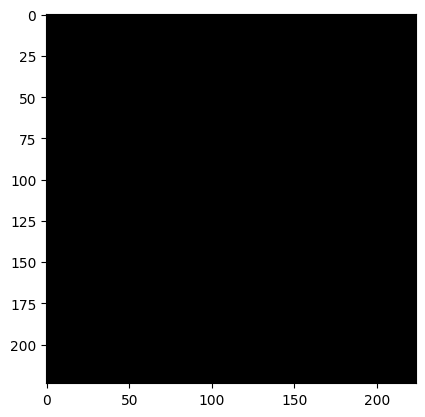

[[[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 ...

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]]


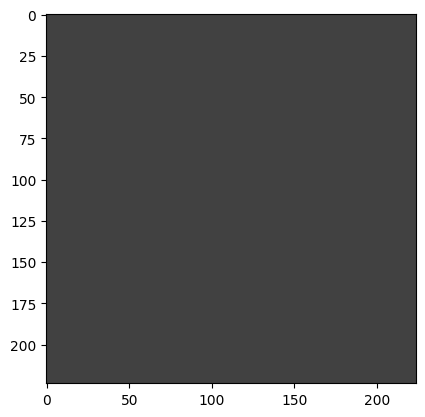

[[[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 ...

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]]


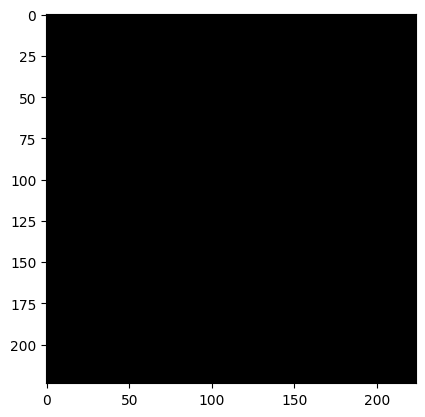

[[[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 ...

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]]


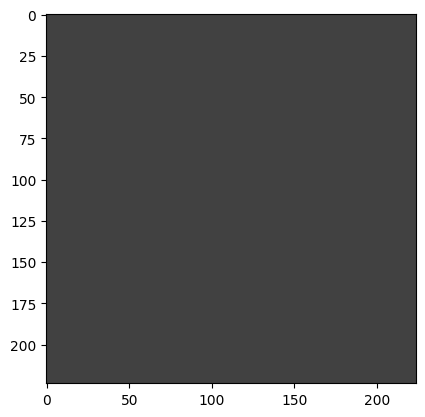

[[[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 ...

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]]


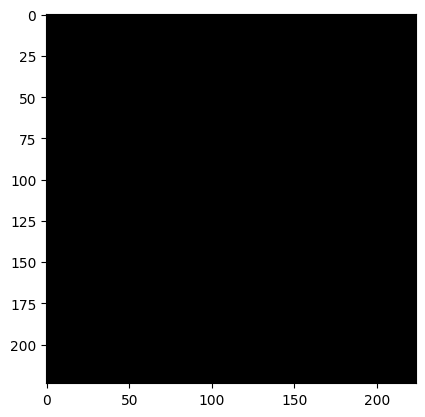

(10, 224, 224, 3)
Epoch 3
[[[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 ...

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]]


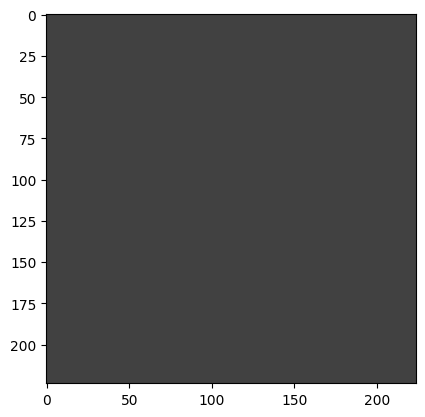

[[[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 ...

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]]


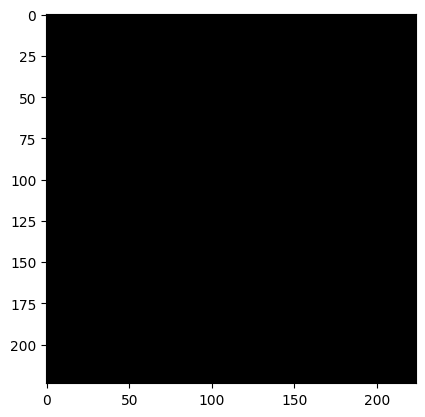

[[[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 ...

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]]


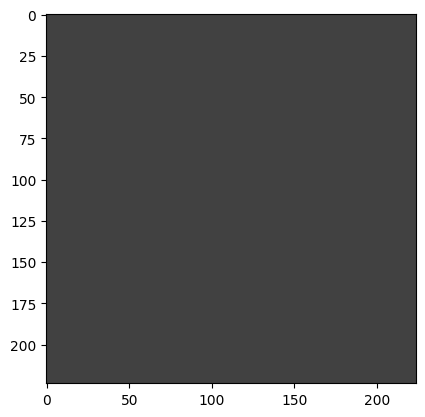

[[[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 ...

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]]


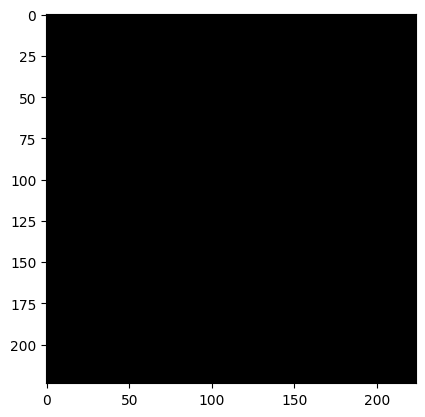

[[[0.25602114 0.25602114 0.25602114]
  [0.25602114 0.25602114 0.25602114]
  [0.25602114 0.25602114 0.25602114]
  ...
  [0.256      0.256      0.256     ]
  [0.256      0.256      0.256     ]
  [0.256      0.256      0.256     ]]

 [[0.25600708 0.25600708 0.25600708]
  [0.25600708 0.25600708 0.25600708]
  [0.25600708 0.25600708 0.25600708]
  ...
  [0.256      0.256      0.256     ]
  [0.256      0.256      0.256     ]
  [0.256      0.256      0.256     ]]

 [[0.256      0.256      0.256     ]
  [0.256      0.256      0.256     ]
  [0.256      0.256      0.256     ]
  ...
  [0.256      0.256      0.256     ]
  [0.256      0.256      0.256     ]
  [0.256      0.256      0.256     ]]

 ...

 [[0.256      0.256      0.256     ]
  [0.256      0.256      0.256     ]
  [0.256      0.256      0.256     ]
  ...
  [0.256      0.256      0.256     ]
  [0.256      0.256      0.256     ]
  [0.256      0.256      0.256     ]]

 [[0.256      0.256      0.256     ]
  [0.256      0.256      0.256     ]


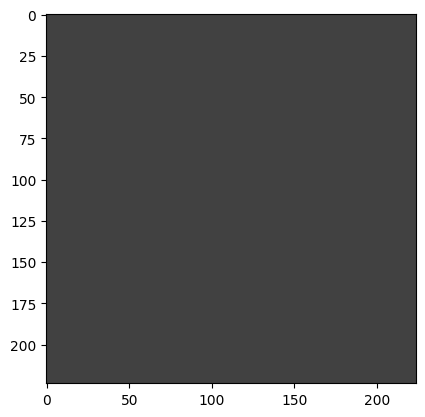

[[[-0.99990773 -0.99990773 -0.99990773]
  [-0.99990773 -0.99990773 -0.99990773]
  [-0.99990773 -0.99990773 -0.99990773]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 [[-0.99996924 -0.99996924 -0.99996924]
  [-0.99996924 -0.99996924 -0.99996924]
  [-0.99996924 -0.99996924 -0.99996924]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 [[-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 ...

 [[-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 [

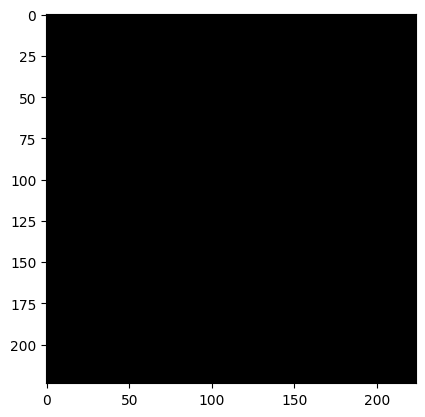

[[[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 ...

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]]


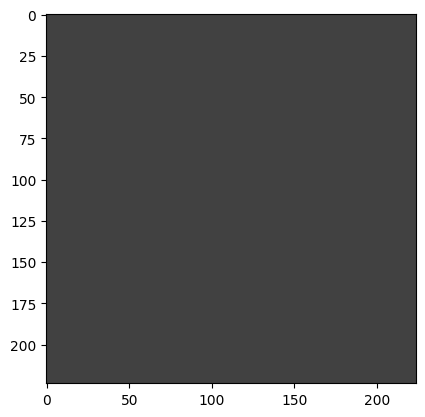

[[[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 ...

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]]


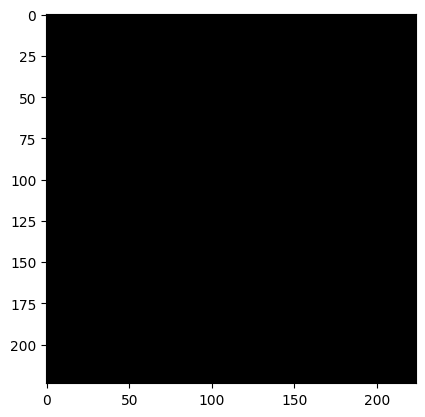

[[[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 ...

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]]


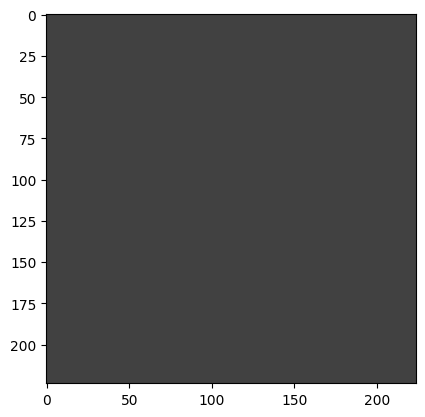

[[[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 ...

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]]


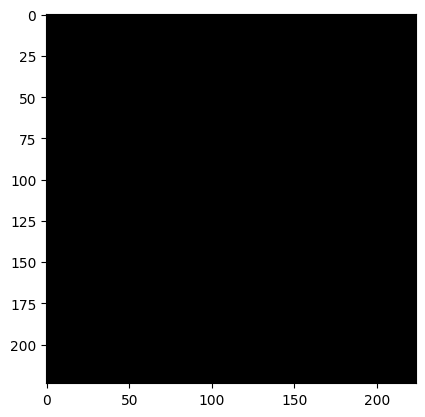

[[[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 ...

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]]


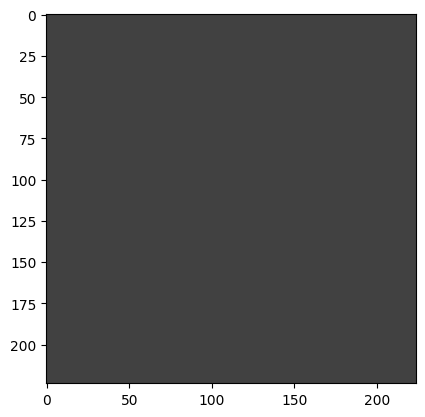

[[[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 ...

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]]


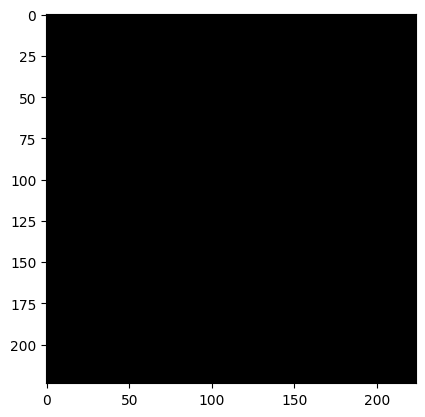

[[[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 ...

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]]


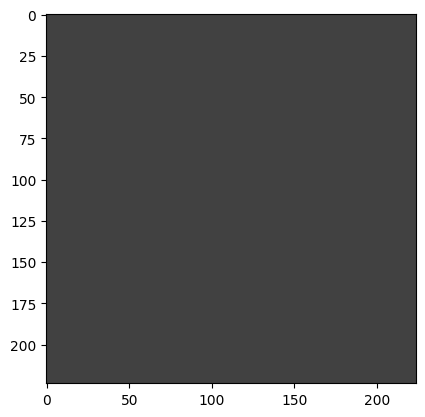

[[[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 ...

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]]


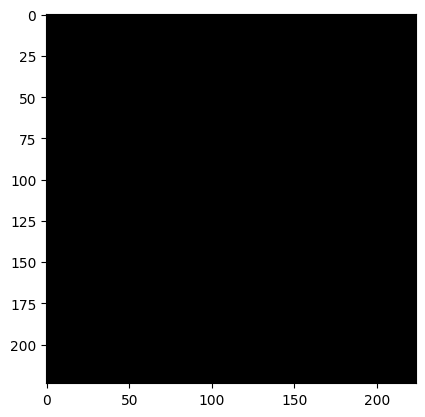

(10, 224, 224, 3)
Epoch 4
[[[0.256      0.256      0.256     ]
  [0.25600708 0.25600708 0.25600708]
  [0.25600708 0.25600708 0.25600708]
  ...
  [0.256      0.256      0.256     ]
  [0.256      0.256      0.256     ]
  [0.256      0.256      0.256     ]]

 [[0.25600708 0.25600708 0.25600708]
  [0.2560141  0.2560141  0.2560141 ]
  [0.2560141  0.2560141  0.2560141 ]
  ...
  [0.25600708 0.25600708 0.25600708]
  [0.25600708 0.25600708 0.25600708]
  [0.25600708 0.25600708 0.25600708]]

 [[0.25602114 0.25602114 0.25602114]
  [0.25602818 0.25602818 0.25602818]
  [0.25602818 0.25602818 0.25602818]
  ...
  [0.2560141  0.2560141  0.2560141 ]
  [0.2560141  0.2560141  0.2560141 ]
  [0.2560141  0.2560141  0.2560141 ]]

 ...

 [[0.2560141  0.2560141  0.2560141 ]
  [0.2560141  0.2560141  0.2560141 ]
  [0.2560141  0.2560141  0.2560141 ]
  ...
  [0.2560141  0.2560141  0.2560141 ]
  [0.2560141  0.2560141  0.2560141 ]
  [0.2560141  0.2560141  0.2560141 ]]

 [[0.25600708 0.25600708 0.25600708]
  [0.256007

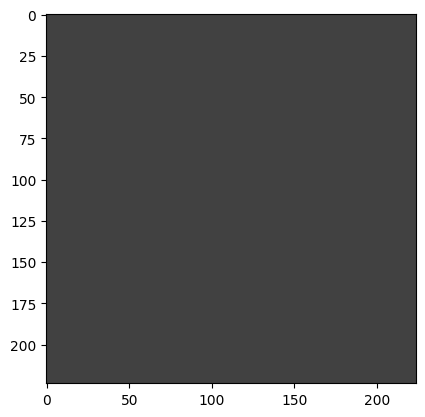

[[[-1.         -1.         -1.        ]
  [-0.99996924 -0.99996924 -0.99996924]
  [-0.99996924 -0.99996924 -0.99996924]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 [[-0.99996924 -0.99996924 -0.99996924]
  [-0.9999385  -0.9999385  -0.9999385 ]
  [-0.9999385  -0.9999385  -0.9999385 ]
  ...
  [-0.99996924 -0.99996924 -0.99996924]
  [-0.99996924 -0.99996924 -0.99996924]
  [-0.99996924 -0.99996924 -0.99996924]]

 [[-0.99990773 -0.99990773 -0.99990773]
  [-0.999877   -0.999877   -0.999877  ]
  [-0.999877   -0.999877   -0.999877  ]
  ...
  [-0.9999385  -0.9999385  -0.9999385 ]
  [-0.9999385  -0.9999385  -0.9999385 ]
  [-0.9999385  -0.9999385  -0.9999385 ]]

 ...

 [[-0.9999385  -0.9999385  -0.9999385 ]
  [-0.9999385  -0.9999385  -0.9999385 ]
  [-0.9999385  -0.9999385  -0.9999385 ]
  ...
  [-0.9999385  -0.9999385  -0.9999385 ]
  [-0.9999385  -0.9999385  -0.9999385 ]
  [-0.9999385  -0.9999385  -0.9999385 ]]

 [

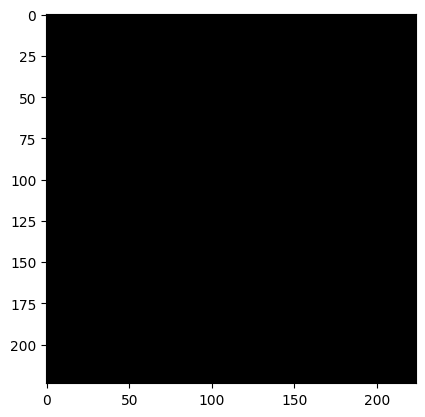

[[[0.2560141  0.2560141  0.2560141 ]
  [0.2560141  0.2560141  0.2560141 ]
  [0.2560141  0.2560141  0.2560141 ]
  ...
  [0.2560141  0.2560141  0.2560141 ]
  [0.2560141  0.2560141  0.2560141 ]
  [0.2560141  0.2560141  0.2560141 ]]

 [[0.2560141  0.2560141  0.2560141 ]
  [0.2560141  0.2560141  0.2560141 ]
  [0.2560141  0.2560141  0.2560141 ]
  ...
  [0.2560141  0.2560141  0.2560141 ]
  [0.2560141  0.2560141  0.2560141 ]
  [0.2560141  0.2560141  0.2560141 ]]

 [[0.2560141  0.2560141  0.2560141 ]
  [0.2560141  0.2560141  0.2560141 ]
  [0.2560141  0.2560141  0.2560141 ]
  ...
  [0.2560141  0.2560141  0.2560141 ]
  [0.2560141  0.2560141  0.2560141 ]
  [0.2560141  0.2560141  0.2560141 ]]

 ...

 [[0.2560141  0.2560141  0.2560141 ]
  [0.2560141  0.2560141  0.2560141 ]
  [0.2560141  0.2560141  0.2560141 ]
  ...
  [0.25600708 0.25600708 0.25600708]
  [0.256      0.256      0.256     ]
  [0.256      0.256      0.256     ]]

 [[0.2560141  0.2560141  0.2560141 ]
  [0.2560141  0.2560141  0.2560141 ]


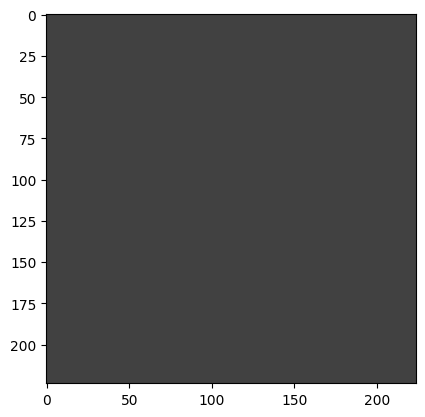

[[[-0.9999385  -0.9999385  -0.9999385 ]
  [-0.9999385  -0.9999385  -0.9999385 ]
  [-0.9999385  -0.9999385  -0.9999385 ]
  ...
  [-0.9999385  -0.9999385  -0.9999385 ]
  [-0.9999385  -0.9999385  -0.9999385 ]
  [-0.9999385  -0.9999385  -0.9999385 ]]

 [[-0.9999385  -0.9999385  -0.9999385 ]
  [-0.9999385  -0.9999385  -0.9999385 ]
  [-0.9999385  -0.9999385  -0.9999385 ]
  ...
  [-0.9999385  -0.9999385  -0.9999385 ]
  [-0.9999385  -0.9999385  -0.9999385 ]
  [-0.9999385  -0.9999385  -0.9999385 ]]

 [[-0.9999385  -0.9999385  -0.9999385 ]
  [-0.9999385  -0.9999385  -0.9999385 ]
  [-0.9999385  -0.9999385  -0.9999385 ]
  ...
  [-0.9999385  -0.9999385  -0.9999385 ]
  [-0.9999385  -0.9999385  -0.9999385 ]
  [-0.9999385  -0.9999385  -0.9999385 ]]

 ...

 [[-0.9999385  -0.9999385  -0.9999385 ]
  [-0.9999385  -0.9999385  -0.9999385 ]
  [-0.9999385  -0.9999385  -0.9999385 ]
  ...
  [-0.99996924 -0.99996924 -0.99996924]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 [

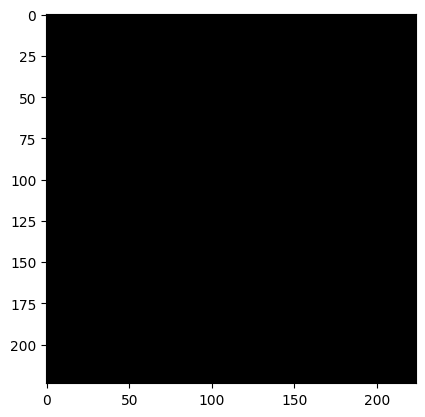

[[[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 ...

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]]


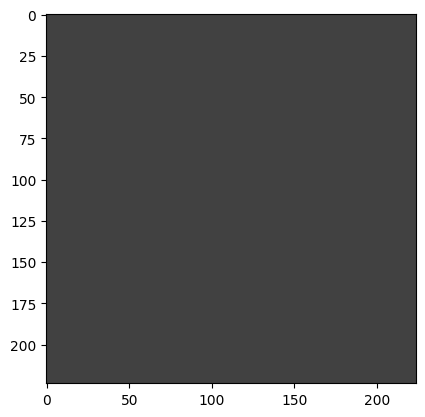

[[[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 ...

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]]


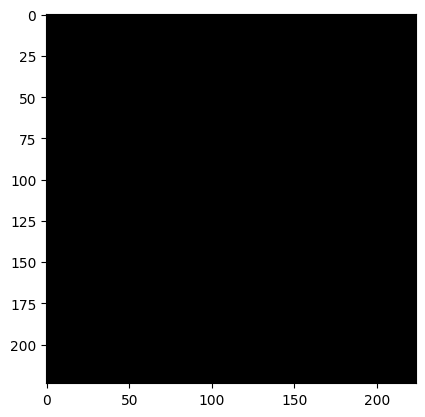

[[[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 ...

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]]


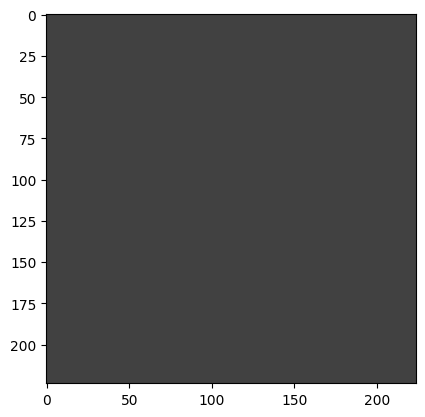

[[[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 ...

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]]


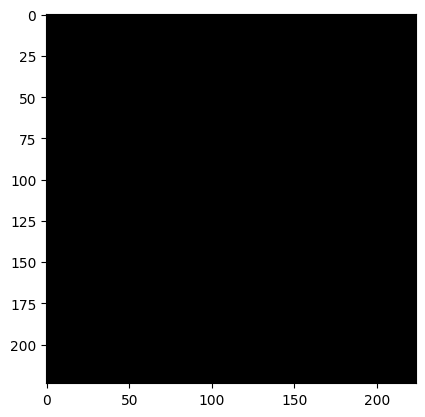

[[[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 ...

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]]


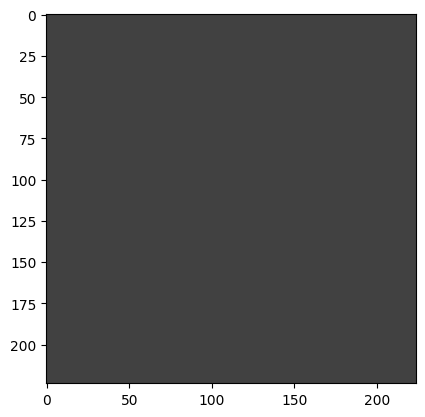

[[[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 ...

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]]


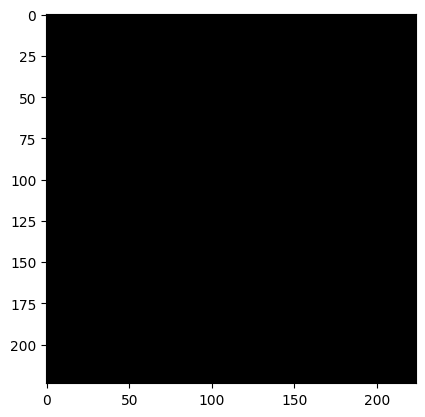

[[[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 ...

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]]


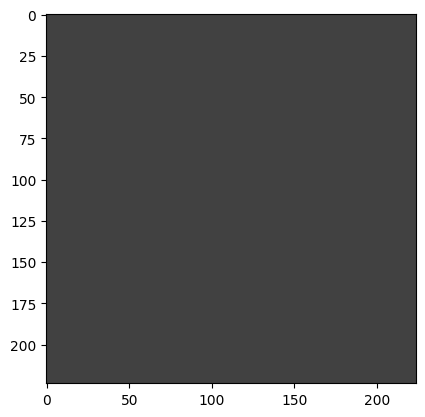

[[[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 ...

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]]


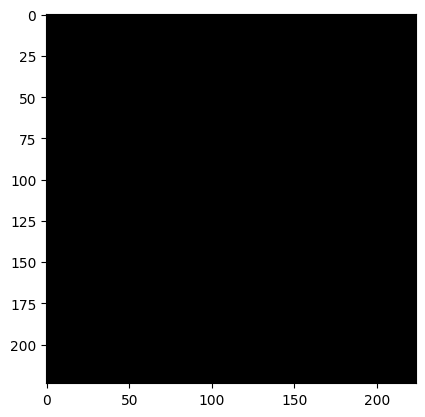

[[[0.256      0.256      0.256     ]
  [0.25600708 0.25600708 0.25600708]
  [0.25600708 0.25600708 0.25600708]
  ...
  [0.256      0.256      0.256     ]
  [0.256      0.256      0.256     ]
  [0.256      0.256      0.256     ]]

 [[0.25600708 0.25600708 0.25600708]
  [0.25600708 0.25600708 0.25600708]
  [0.2560141  0.2560141  0.2560141 ]
  ...
  [0.25600708 0.25600708 0.25600708]
  [0.25600708 0.25600708 0.25600708]
  [0.25600708 0.25600708 0.25600708]]

 [[0.25602818 0.25602818 0.25602818]
  [0.25602818 0.25602818 0.25602818]
  [0.2560352  0.2560352  0.2560352 ]
  ...
  [0.2560141  0.2560141  0.2560141 ]
  [0.2560141  0.2560141  0.2560141 ]
  [0.2560141  0.2560141  0.2560141 ]]

 ...

 [[0.2560141  0.2560141  0.2560141 ]
  [0.2560141  0.2560141  0.2560141 ]
  [0.2560141  0.2560141  0.2560141 ]
  ...
  [0.2560141  0.2560141  0.2560141 ]
  [0.2560141  0.2560141  0.2560141 ]
  [0.2560141  0.2560141  0.2560141 ]]

 [[0.256      0.256      0.256     ]
  [0.256      0.256      0.256     ]


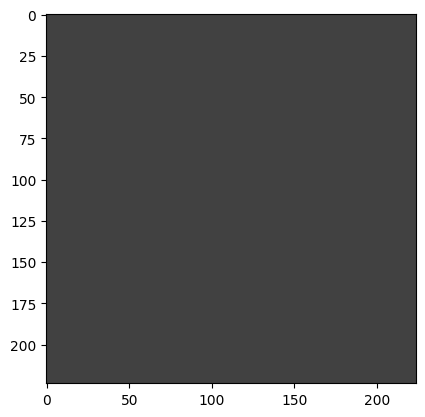

[[[-1.         -1.         -1.        ]
  [-0.99996924 -0.99996924 -0.99996924]
  [-0.99996924 -0.99996924 -0.99996924]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 [[-0.99996924 -0.99996924 -0.99996924]
  [-0.99996924 -0.99996924 -0.99996924]
  [-0.9999385  -0.9999385  -0.9999385 ]
  ...
  [-0.99996924 -0.99996924 -0.99996924]
  [-0.99996924 -0.99996924 -0.99996924]
  [-0.99996924 -0.99996924 -0.99996924]]

 [[-0.999877   -0.999877   -0.999877  ]
  [-0.999877   -0.999877   -0.999877  ]
  [-0.9998462  -0.9998462  -0.9998462 ]
  ...
  [-0.9999385  -0.9999385  -0.9999385 ]
  [-0.9999385  -0.9999385  -0.9999385 ]
  [-0.9999385  -0.9999385  -0.9999385 ]]

 ...

 [[-0.9999385  -0.9999385  -0.9999385 ]
  [-0.9999385  -0.9999385  -0.9999385 ]
  [-0.9999385  -0.9999385  -0.9999385 ]
  ...
  [-0.9999385  -0.9999385  -0.9999385 ]
  [-0.9999385  -0.9999385  -0.9999385 ]
  [-0.9999385  -0.9999385  -0.9999385 ]]

 [

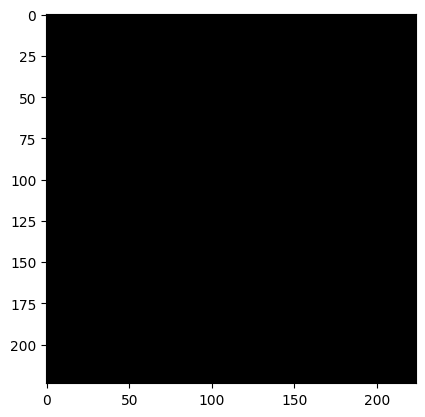

(10, 224, 224, 3)
Epoch 5
[[[0.256      0.256      0.256     ]
  [0.256      0.256      0.256     ]
  [0.256      0.256      0.256     ]
  ...
  [0.256      0.256      0.256     ]
  [0.256      0.256      0.256     ]
  [0.256      0.256      0.256     ]]

 [[0.256      0.256      0.256     ]
  [0.256      0.256      0.256     ]
  [0.256      0.256      0.256     ]
  ...
  [0.2560141  0.2560141  0.2560141 ]
  [0.2560141  0.2560141  0.2560141 ]
  [0.2560141  0.2560141  0.2560141 ]]

 [[0.256      0.256      0.256     ]
  [0.256      0.256      0.256     ]
  [0.256      0.256      0.256     ]
  ...
  [0.25602114 0.25602114 0.25602114]
  [0.25602114 0.25602114 0.25602114]
  [0.25602114 0.25602114 0.25602114]]

 ...

 [[0.2560141  0.2560141  0.2560141 ]
  [0.2560141  0.2560141  0.2560141 ]
  [0.2560141  0.2560141  0.2560141 ]
  ...
  [0.25602114 0.25602114 0.25602114]
  [0.25602114 0.25602114 0.25602114]
  [0.25602114 0.25602114 0.25602114]]

 [[0.25600708 0.25600708 0.25600708]
  [0.256007

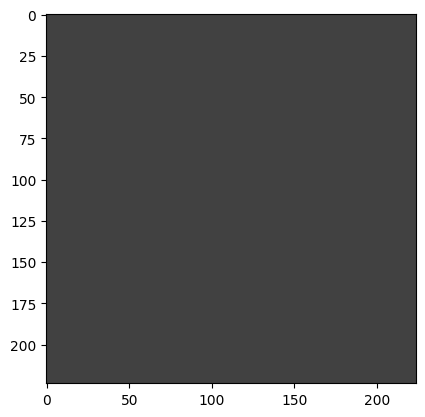

[[[-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 [[-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  ...
  [-0.9999385  -0.9999385  -0.9999385 ]
  [-0.9999385  -0.9999385  -0.9999385 ]
  [-0.9999385  -0.9999385  -0.9999385 ]]

 [[-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  ...
  [-0.99990773 -0.99990773 -0.99990773]
  [-0.99990773 -0.99990773 -0.99990773]
  [-0.99990773 -0.99990773 -0.99990773]]

 ...

 [[-0.9999385  -0.9999385  -0.9999385 ]
  [-0.9999385  -0.9999385  -0.9999385 ]
  [-0.9999385  -0.9999385  -0.9999385 ]
  ...
  [-0.99990773 -0.99990773 -0.99990773]
  [-0.99990773 -0.99990773 -0.99990773]
  [-0.99990773 -0.99990773 -0.99990773]]

 [

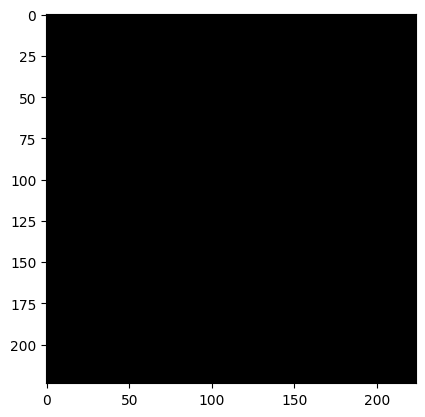

[[[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 ...

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]]


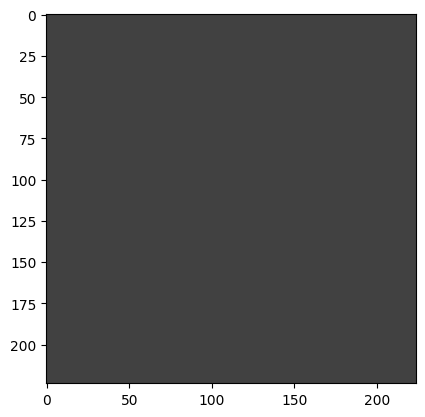

[[[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 ...

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]]


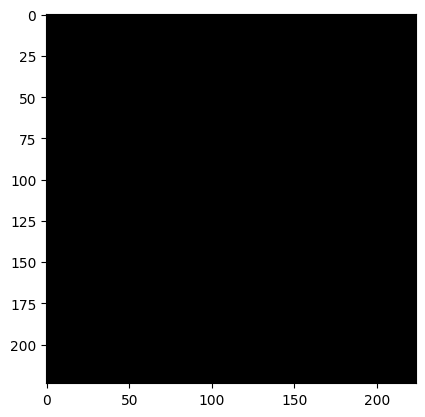

[[[0.256      0.256      0.256     ]
  [0.256      0.256      0.256     ]
  [0.256      0.256      0.256     ]
  ...
  [0.256      0.256      0.256     ]
  [0.256      0.256      0.256     ]
  [0.256      0.256      0.256     ]]

 [[0.256      0.256      0.256     ]
  [0.256      0.256      0.256     ]
  [0.256      0.256      0.256     ]
  ...
  [0.256      0.256      0.256     ]
  [0.256      0.256      0.256     ]
  [0.256      0.256      0.256     ]]

 [[0.25600708 0.25600708 0.25600708]
  [0.25600708 0.25600708 0.25600708]
  [0.25600708 0.25600708 0.25600708]
  ...
  [0.25600708 0.25600708 0.25600708]
  [0.25600708 0.25600708 0.25600708]
  [0.25600708 0.25600708 0.25600708]]

 ...

 [[0.256      0.256      0.256     ]
  [0.256      0.256      0.256     ]
  [0.256      0.256      0.256     ]
  ...
  [0.256      0.256      0.256     ]
  [0.256      0.256      0.256     ]
  [0.256      0.256      0.256     ]]

 [[0.256      0.256      0.256     ]
  [0.256      0.256      0.256     ]


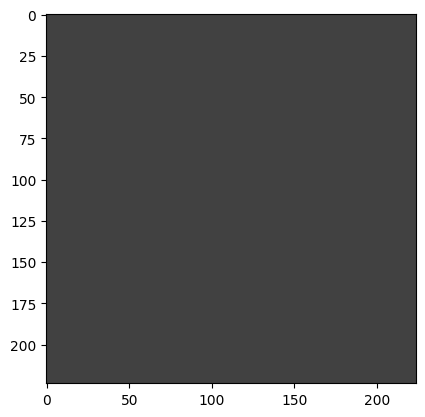

[[[-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 [[-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 [[-0.99996924 -0.99996924 -0.99996924]
  [-0.99996924 -0.99996924 -0.99996924]
  [-0.99996924 -0.99996924 -0.99996924]
  ...
  [-0.99996924 -0.99996924 -0.99996924]
  [-0.99996924 -0.99996924 -0.99996924]
  [-0.99996924 -0.99996924 -0.99996924]]

 ...

 [[-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 [

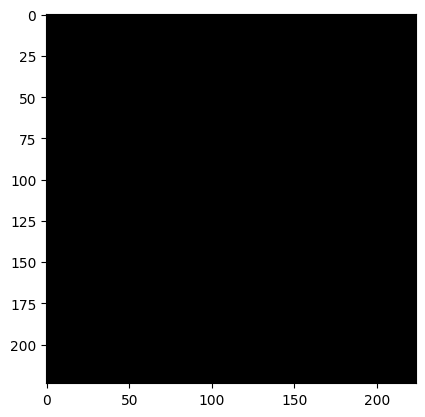

[[[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 ...

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]]


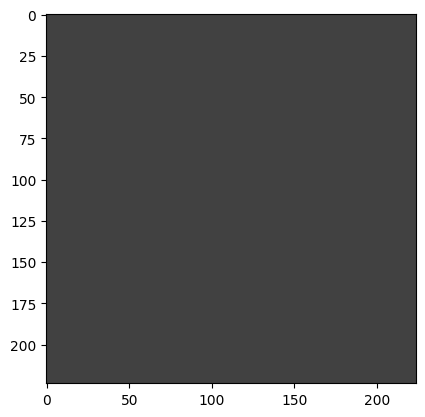

[[[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 ...

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]]


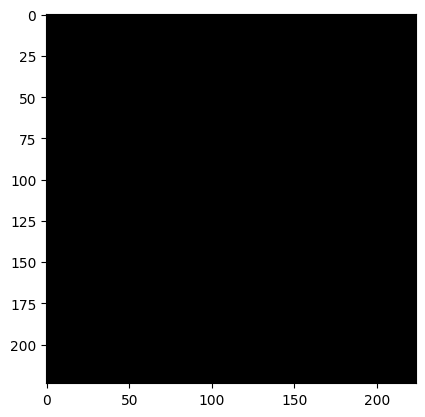

[[[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 ...

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]

 [[0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  ...
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]
  [0.256 0.256 0.256]]]


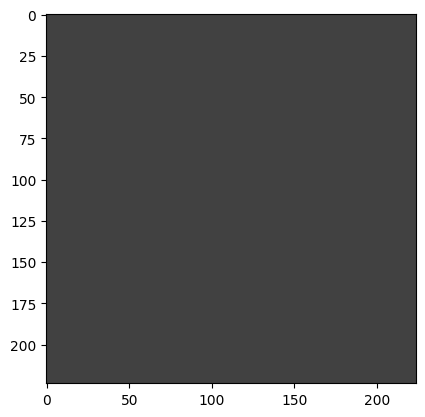

[[[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 ...

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]]


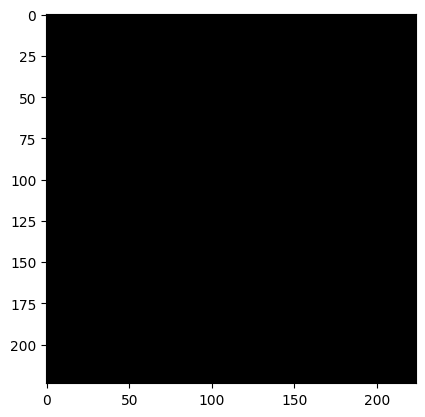

[[[0.256      0.256      0.256     ]
  [0.256      0.256      0.256     ]
  [0.256      0.256      0.256     ]
  ...
  [0.256      0.256      0.256     ]
  [0.256      0.256      0.256     ]
  [0.256      0.256      0.256     ]]

 [[0.256      0.256      0.256     ]
  [0.256      0.256      0.256     ]
  [0.256      0.256      0.256     ]
  ...
  [0.2560141  0.2560141  0.2560141 ]
  [0.2560141  0.2560141  0.2560141 ]
  [0.2560141  0.2560141  0.2560141 ]]

 [[0.2560141  0.2560141  0.2560141 ]
  [0.2560141  0.2560141  0.2560141 ]
  [0.2560141  0.2560141  0.2560141 ]
  ...
  [0.25602114 0.25602114 0.25602114]
  [0.25602114 0.25602114 0.25602114]
  [0.25602114 0.25602114 0.25602114]]

 ...

 [[0.2560141  0.2560141  0.2560141 ]
  [0.2560141  0.2560141  0.2560141 ]
  [0.2560141  0.2560141  0.2560141 ]
  ...
  [0.2560141  0.2560141  0.2560141 ]
  [0.2560141  0.2560141  0.2560141 ]
  [0.2560141  0.2560141  0.2560141 ]]

 [[0.25600708 0.25600708 0.25600708]
  [0.25600708 0.25600708 0.25600708]


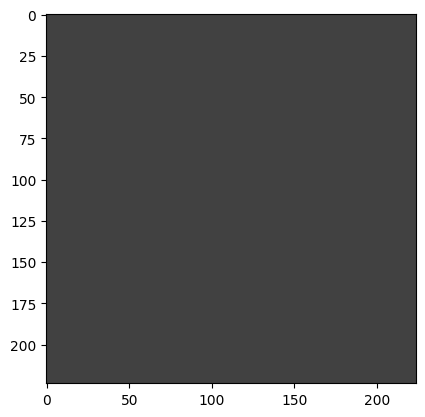

[[[-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 [[-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  ...
  [-0.9999385  -0.9999385  -0.9999385 ]
  [-0.9999385  -0.9999385  -0.9999385 ]
  [-0.9999385  -0.9999385  -0.9999385 ]]

 [[-0.9999385  -0.9999385  -0.9999385 ]
  [-0.9999385  -0.9999385  -0.9999385 ]
  [-0.9999385  -0.9999385  -0.9999385 ]
  ...
  [-0.99990773 -0.99990773 -0.99990773]
  [-0.99990773 -0.99990773 -0.99990773]
  [-0.99990773 -0.99990773 -0.99990773]]

 ...

 [[-0.9999385  -0.9999385  -0.9999385 ]
  [-0.9999385  -0.9999385  -0.9999385 ]
  [-0.9999385  -0.9999385  -0.9999385 ]
  ...
  [-0.9999385  -0.9999385  -0.9999385 ]
  [-0.9999385  -0.9999385  -0.9999385 ]
  [-0.9999385  -0.9999385  -0.9999385 ]]

 [

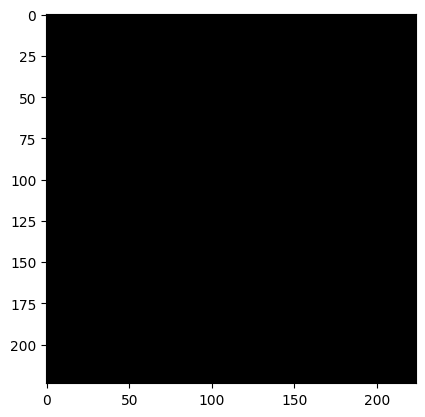

[[[0.256      0.256      0.256     ]
  [0.256      0.256      0.256     ]
  [0.256      0.256      0.256     ]
  ...
  [0.256      0.256      0.256     ]
  [0.256      0.256      0.256     ]
  [0.256      0.256      0.256     ]]

 [[0.256      0.256      0.256     ]
  [0.256      0.256      0.256     ]
  [0.256      0.256      0.256     ]
  ...
  [0.256      0.256      0.256     ]
  [0.256      0.256      0.256     ]
  [0.256      0.256      0.256     ]]

 [[0.25600708 0.25600708 0.25600708]
  [0.25600708 0.25600708 0.25600708]
  [0.25600708 0.25600708 0.25600708]
  ...
  [0.25600708 0.25600708 0.25600708]
  [0.25600708 0.25600708 0.25600708]
  [0.25600708 0.25600708 0.25600708]]

 ...

 [[0.2560141  0.2560141  0.2560141 ]
  [0.2560141  0.2560141  0.2560141 ]
  [0.2560141  0.2560141  0.2560141 ]
  ...
  [0.2560141  0.2560141  0.2560141 ]
  [0.2560141  0.2560141  0.2560141 ]
  [0.2560141  0.2560141  0.2560141 ]]

 [[0.25600708 0.25600708 0.25600708]
  [0.25600708 0.25600708 0.25600708]


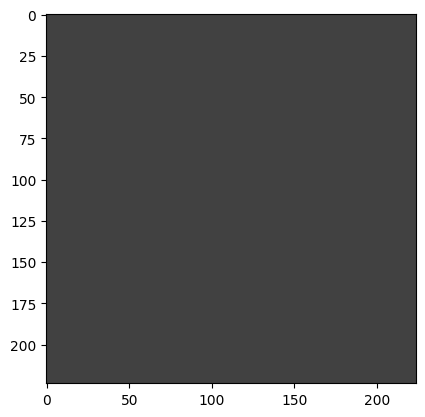

[[[-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 [[-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 [[-0.99996924 -0.99996924 -0.99996924]
  [-0.99996924 -0.99996924 -0.99996924]
  [-0.99996924 -0.99996924 -0.99996924]
  ...
  [-0.99996924 -0.99996924 -0.99996924]
  [-0.99996924 -0.99996924 -0.99996924]
  [-0.99996924 -0.99996924 -0.99996924]]

 ...

 [[-0.9999385  -0.9999385  -0.9999385 ]
  [-0.9999385  -0.9999385  -0.9999385 ]
  [-0.9999385  -0.9999385  -0.9999385 ]
  ...
  [-0.9999385  -0.9999385  -0.9999385 ]
  [-0.9999385  -0.9999385  -0.9999385 ]
  [-0.9999385  -0.9999385  -0.9999385 ]]

 [

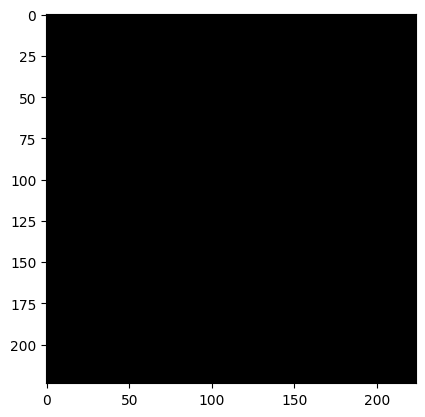

(10, 224, 224, 3)


(10, 224, 224, 3)


In [ ]:
#from keras.datasets import mnist
import gc
import argparse

class Option():
    """
    Empty class to hold the gan options
    """
    def __init__(self, gan_type, alpha, seed, c_type, n_epochs, dataset, loss_type, lambda_d, lambda_c, num_images, gp, gen_lr, dis_lr, q_lr, gp_coef, alpha_d, alpha_g, k, shifted, l1):
        self.gan_type = gan_type
        self.alpha = alpha
        self.seed = seed
        self.c_type = c_type
        self.n_epochs = n_epochs
        self.dataset = dataset
        self.loss_type = loss_type
        self.lambda_d = lambda_d
        self.lambda_c = lambda_c
        self.num_images = num_images
        self.gp = gp
        self.gen_lr = gen_lr
        self.dis_lr = dis_lr
        self.q_lr = q_lr
        self.gp_coef = gp_coef
        self.alpha_d = alpha_d
        self.alpha_g = alpha_g
        self.k = k
        self.shifted = shifted
        self.l1 = l1
        return
#set up options
opts = Option(gan_type='alpha', alpha=3.0, seed=42, c_type='discrete', n_epochs=5, dataset='mri', loss_type='vanilla', lambda_d=1.0, lambda_c=0.1, num_images=1, gp=False, gen_lr=0.0002, dis_lr=0.0002, q_lr=0.0002, gp_coef=5.0, alpha_d=3.0, alpha_g=3.0, k=2.0, shifted=False, l1=False)

# Define an alphagan to test
gan = AlphaGAN(opts)

#gan.print_dataset()

# sets data to mnist and configures it for the gan
gan.dataset = 'mri'
gan.get_data()



#build the generative network
gan.build_gan()

gan.train()

gan.save_generated_images(1)

#gan.compute_fid()

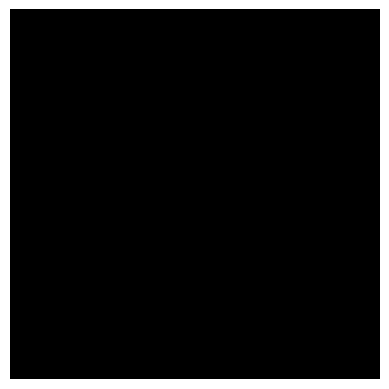

In [ ]:


check_img = np.load('/content/AlphaGAN/mri/alpha-d3.0-g3.0/v15/img/predictions1.npy')

plt.imshow(check_img[0])
plt.axis("off")
plt.show()
